In [27]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from pathlib import Path
import yfinance as yf
import time
import plotly.express as px
from datetime import timedelta

In [ ]:
# Load backtest orders from path: /Users/vandanchopra/Vandan_Personal_Folder/CODE_STUFF/Projects/mathematricks/db/vault/backtest_reports/alsdkjasldkqw923yasjdaskd23328y_1/backtest_orders.pkl


def calculate_multi_leg_order_profit(count, multi_leg_order):
        sell_orders = []
        buy_orders = []
        signal_id = multi_leg_order[0]['signal_id']

        buy_quantity = 0
        sell_quantity = 0
        # Separate out all sell and buy orders
        for order in multi_leg_order:
            symbol = order['symbol']
            if order['orderDirection'] == 'SELL' and order['status'] == 'closed':
                sell_orders.append(order)
                sell_quantity += order['orderQuantity']
            elif order['orderDirection'] == 'BUY' and order['status'] == 'closed':
                buy_orders.append(order)
                buy_quantity += order['orderQuantity']

        if buy_quantity == sell_quantity:
            total_profit = 0
            # Assuming orders are processed in pairs (e.g., first sell with first buy, second sell with second buy)
            for sell_order, buy_order in zip(sell_orders, buy_orders):
                sell_price = sell_order.get('fill_price')
                buy_price = buy_order.get('fill_price')
                quantity = buy_quantity #min(sell_order.get('orderQuantity'), buy_order.get('orderQuantity'))

                # Calculate profit for the matching sell and buy orders
                profit = (sell_price - buy_price) * quantity
                total_profit += profit
            # self.logger.info({'order':multi_leg_order})
            # self.logger.info(f"Total profit for multi-leg order: {total_profit}")
            # raise AssertionError('PnL calculation not implemented yet.') 
            return total_profit
        else:
            return 0


In [29]:
# Till this section this is your code simply execute this field as well.
testname = 'e69c9c193856ccf322ef0db21cb59676841f63def2a5dd9ccd3ab3d69960c423'
save_folder = "/Users/vandanchopra/Vandan_Personal_Folder/CODE_STUFF/Projects/mathematricks/db/data/yahoo/1d"
test_folder_path = f'/Users/vandanchopra/Vandan_Personal_Folder/CODE_STUFF/Projects/mathematricks/db/vault/backtest_reports/{testname}'
backtest_output = load_backtest_output(test_folder_path)
open_orders = backtest_output['open_orders']
closed_orders = backtest_output['closed_orders']
config_dict = backtest_output['config_dict']
rolling_window = 60


### Close orders and do cleanup
### Here we are processing the and filtering it. We have removed the dictionars with cancelled orders. We are only using the entry and exit order dictionary
### Also we have removed history from both orders to process the data faster as it is not required.
### We have drop_history=False, we will delete history only if required. set this to True to delete history

In [30]:
def process_and_filter_data(nested_list, drop_history=False):

    for sublist in nested_list:
        # Process each dictionary in the sublist
        for i in range(len(sublist) - 1, -1, -1):  # Iterate in reverse to allow in-place removal
            d = sublist[i]
            
            # Remove dict with status 'cancelled'
            if d.get('status') == 'cancelled':
                sublist.pop(i)
                continue
                
            if drop_history:
                # Remove 'history' key if present
                d.pop('history', None)
            
            # Update dict2 status from 'open' to 'closed'
            if d.get('status') == 'open':
                d['status'] = 'closed'
                
                # Ensure 'symbol_ltp' is a dictionary or check if it has values()
                if isinstance(d.get('symbol_ltp'), dict):
                    d['fill_price'] = list(d['symbol_ltp'].values())[0]  # Safely access values
                else:
                    # Handle missing or incorrect structure of symbol_ltp
                    d['fill_price'] = None  # or any default value
                
                # Set 'filled_timestamp'
                d['filled_timestamp'] = d.get('timestamp', None)  
    
    # Filter out empty sublists
    return [sublist for sublist in nested_list if sublist]

#  We have removed the history key from both dict as they are not required for most calculation
#  drop_history=False to keep the history

#Processing Open order to make them close, and remove history
open_orders_list = process_and_filter_data(open_orders, drop_history=True)

#Processing Closed orders to remove history
closed_orders_list = process_and_filter_data(closed_orders, drop_history=True)

#Merge both orders
final_list = open_orders_list + closed_orders_list
# Step 2: Sort the filtered orders by exit order `filled_timestamp`
sorted_orders = sorted(final_list, key=lambda x: x[1]['filled_timestamp'])

# Step 3: Fetch the first and last `filled_timestamp` with buffer
start_date = sorted_orders[0][1]['filled_timestamp'] - timedelta(days=365)
end_date = sorted_orders[-1][1]['filled_timestamp'] + timedelta(days=365)

# start_date = start_date.replace(tzinfo=None)
# end_date = end_date.replace(tzinfo=None)


**Download data from yfinance.**


Run this function first because 

This function checks if all csv files present in the folder. 

If not present it will automatically download and save in the  **index_data** folder


In [31]:
def load_and_save_index_data(indices, start_date, end_date, folder):

    # Ensure the folder exists
    os.makedirs(folder, exist_ok=True)
    index_files = {}  # Dictionary to store DataFrames for all indices

    for index_name in indices:
        filename = os.path.join(folder, f"{index_name}.csv")

        # Check if the file exists
        if os.path.exists(filename):
            # Read the CSV and parse dates
            data = pd.read_csv(filename, parse_dates=['datetime'], index_col='datetime')
        else:
            # Download max data from Yahoo Finance
            data = yf.download(index_name, period='max', interval="1d")

            if data.empty:
                continue
            
            # Process downloaded data
            if isinstance(data.columns, pd.MultiIndex):  # Handle multi-index columns
                data.columns = data.columns.droplevel(1)

            # Reset index and rename columns
            data.reset_index(inplace=True)
            data.rename(columns={'Date': 'datetime'}, inplace=True)
            data.set_index('datetime', inplace=True)
            data.columns = [col.lower() for col in data.columns]  # Lowercase column names
            
            # Save the processed data to CSV
            data.to_csv(filename)

        # Ensure the index is datetime and filter by date range
        data.index = pd.to_datetime(data.index)  # Ensure datetime index
        data = data[(data.index >= start_date) & (data.index <= end_date)]
        
        if data.empty:
            continue

        # Store the processed DataFrame in the dictionary
        index_files[index_name] = data

    return index_files


# Current we are downloading csv file for below three index
indices = ["^DJI", "^IXIC", "^GSPC"]

index_data_dict = load_and_save_index_data(indices, start_date, end_date, save_folder)

### This below function calculates profit/loss from the orders  **(exitPrice - entryPrice) * orderQuantity**

This function also plot the progress lines for 3 indexes provided earlier.

In [32]:
def plot_cumulative_returns_and_indices(trade_data, index_data_dict, starting_capital):
    # Extract profit/loss data
    trade_timestamps = []
    profit_loss = []
    
    for trade in trade_data:
        entry_order, exit_order = trade
            
        # Check order direction to determine long or short
        if entry_order['orderDirection'] == 'BUY':  # Long trade
            profit = (exit_order['fill_price'] - entry_order['fill_price']) * entry_order['orderQuantity']
        elif entry_order['orderDirection'] == 'SELL':  # Short trade
            profit = (entry_order['fill_price'] - exit_order['fill_price']) * entry_order['orderQuantity']
        else:
            profit = 0  # Handle any undefined order direction

        trade_timestamps.append(exit_order['filled_timestamp'])
        profit_loss.append(profit)
    
    # Create a DataFrame for sorting
    trade_df = pd.DataFrame({
        "filled_timestamp": trade_timestamps,
        "profit_loss": profit_loss
    })
    
    # Sort the data by exit timestamp
    trade_df = trade_df.sort_values(by="filled_timestamp").reset_index(drop=True)
    daily_profit_loss = trade_df.groupby("filled_timestamp")["profit_loss"].sum().reset_index()
    # # Calculate `cumulative_return` by cumulatively summing `profit_loss`
    daily_profit_loss["cumulative_pnl"] = daily_profit_loss["profit_loss"].cumsum()
    
    daily_profit_loss["account_value"] = daily_profit_loss["cumulative_pnl"] + starting_capital
    # pct growth for cumulative pnl
    daily_profit_loss["cumulative_return"] = ((daily_profit_loss["account_value"] / daily_profit_loss["account_value"].iloc[0]) - 1) * 100
    
    # # Forward-fill missing dates if needed
    daily_profit_loss = daily_profit_loss.set_index("filled_timestamp")
    daily_profit_loss = daily_profit_loss.asfreq("D", method="ffill").reset_index()
    # # Calculate cumulative profit/loss and returns
    # trade_df['cumulative_profit_loss'] = trade_df['profit_loss'].cumsum()
    # trade_df['cumulative_return'] = trade_df['cumulative_profit_loss'] 
    trade_df = daily_profit_loss
    
    min_max = [0 , 0]
    for index_data in index_data_dict.values():
        # Calculate percentage growth
        index_data["cumulative_return"] = ((index_data["close"] / index_data["close"].iloc[0]) - 1) * 100
        min_max[0] = min(min_max[0], index_data["cumulative_return"].min())
        min_max[1] = max(min_max[1], index_data["cumulative_return"].max())
    
    # Create figure
    fig = go.Figure()

    # Plot cumulative returns for trade data
    fig.add_trace(go.Scatter(
        x=trade_df['filled_timestamp'],
        y=trade_df['cumulative_return'],
        mode='lines',
        name='Cumulative Return (Trades)',
        line=dict(color='red'),
        yaxis="y1"  # Use the left y-axis
    ))

    # Define colors for different indices
    index_colors = ['cyan', 'pink', 'orange']
    
    # Plot index growth
    for i, (index_name, df) in enumerate(index_data_dict.items()):
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df['cumulative_return'],
            mode='lines',
            name=f'{index_name} cumulative_return',
            line=dict(color=index_colors[i % len(index_colors)]),  # Cycle through the colors
            yaxis="y2"  # Use the right y-axis
        ))

    # Update layout for dual y-axis with adjustments to ensure text and lines don't overlap
    fig.update_layout(
        title="Trade Cumulative Returns and Index Performance",
        xaxis=dict(
            title="Date",
            titlefont=dict(size=12),
            tickfont=dict(size=10)
        ),
        yaxis=dict(
            title="Cumulative Return (Strategy)",
            titlefont=dict(color="white", size=12),
            tickfont=dict(color="white", size=10),
            range=[min(trade_df['cumulative_return']) - 0.1, max(trade_df['cumulative_return']) + 0.1],  # Adjust y-axis range
            side="right",
        ),
        yaxis2=dict(
            title="Cumulative Return (Indices)",
            titlefont=dict(color="green", size=12),
            tickfont=dict(color="green", size=10),
            overlaying="y",
            side="left",
            range=min_max
        ),
        template="plotly_dark",
        autosize=True
    )

    fig.show()
    
    trade_df.set_index('filled_timestamp', inplace=True)
    
    return trade_df, index_data

# Example usage
starting_capital = 72181

trade_df_cumulative, index_data = plot_cumulative_returns_and_indices(final_list, index_data_dict, starting_capital)


**Plot Rolling charts**

#### Create functions for the following rolling metrics to be displayed as graphs (rolling_window to be dynamic):
#### 1. Rolling Win Percentage
#### 2. Rolling Sharpe Ratio (For sharpe ratio you will need an index, so use ^IXIC, but the index should be dynamic)
#### 3. Rolling Average Profit (Average of all orders that have made a profit)
#### 4. Rolling Average Loss (Average of all orders that have made a loss)
#### 5. Rolling Profit Factor (Total Profit / Total Loss)
#### 6. Rolling Average Profit for Long Trades
#### 7. Rolling Average Profit for Short Trades
#### 8. Rolling Average Loss for Long Trades
#### 9. Rolling Average Loss for Short Trades


In [33]:
def prepare_trade_data(final_list):
    """
    Convert final_list into a DataFrame, calculate profit/loss for each trade,
    and order the data according to exit_timestamp.
    """
    start_time = time.time()
    
    trade_data = []
    for trade_pair in final_list:
        entry_trade = trade_pair[0]
        exit_trade = trade_pair[1]

        try:
            entry_price = entry_trade['fill_price']
            exit_price = exit_trade.get('fill_price', entry_price)
            exit_timestamp = exit_trade['filled_timestamp']
            trade_type = 'long' if entry_trade['orderDirection'] == 'BUY' else 'short'
            profit_loss = (exit_price - entry_price) * entry_trade['orderQuantity'] if trade_type == 'long' else (entry_price - exit_price) * entry_trade['orderQuantity']
            trade_data.append([exit_timestamp, profit_loss, trade_type])
        except KeyError as e:
            continue

    # Convert to DataFrame
    trade_df = pd.DataFrame(trade_data, columns=['filled_timestamp', 'profit_loss', 'trade_type'])
    
    # Convert 'exit_timestamp' to datetime and floor to day
    trade_df['filled_timestamp'] = pd.to_datetime(trade_df['filled_timestamp']).dt.floor('D')
    
    # Sort by 'exit_timestamp'
    trade_df = trade_df.sort_values(by='filled_timestamp', ascending=True)

    # Ensure 'profit_loss' is in float format
    trade_df['profit_loss'] = trade_df['profit_loss'].astype('float32')

    return trade_df
trade_df = prepare_trade_data(final_list)

/var/folders/d0/_rd9vn610y36nmcvbvp1xr480000gn/T/ipykernel_67730/1964475713.py:59: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



<Axes: title={'center': 'Rolling Sharpe Ratio'}, xlabel='datetime'>

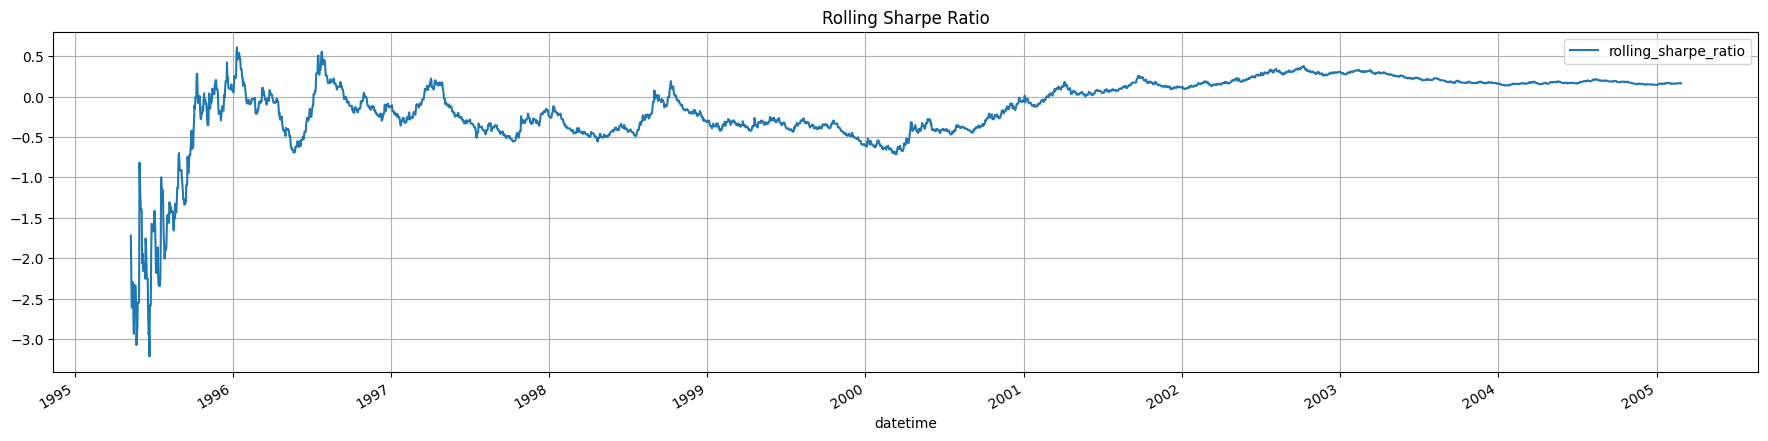

In [34]:
## Sharpe Ratio Calculation
def calculate_sharpe_ratio(trade_df_cumulative, index_data_dict, index_name):
    df1 = trade_df_cumulative['account_value']
    df2 = index_data_dict[index_name]['close']
    df1.index = pd.to_datetime(df1.index)
    df2.index = pd.to_datetime(df2.index)
    # Add 1 minute to df1 index
    df1.index = df1.index + timedelta(seconds=1)
    df1_df = df1.to_frame()
    df2_df = df2.to_frame()
    
    merged_df = df1_df.merge(df2_df, left_index=True, right_index=True, how='inner')
    # Drop rows with NaN values (if any)
    merged_df = merged_df.dropna()
    # rename 'Close' to DJI
    merged_df.rename(columns={'close': index_name}, inplace=True)
    # make the values of the columns float
    merged_df['account_value'] = merged_df['account_value'].astype(float)
    merged_df[index_name] = merged_df[index_name].astype(float)
    
    # Calculate sharpe ratio for the strategy
    strategy_cum_returns = merged_df['account_value']
    dji_values = merged_df[index_name]
    
    # Calculate periodic returns from cumulative returns
    if strategy_cum_returns.iloc[0] == 0:
        strategy_cum_returns.iloc[0] = 0.000000001
    strategy_returns = strategy_cum_returns.pct_change().dropna()
    dji_returns = dji_values.pct_change().dropna()
    periods_per_year = 252
    # Calculate excess returns
    excess_returns = strategy_returns - dji_returns
    # print(excess_returns)

    # Annualized return
    mean_excess_return = excess_returns.mean() * periods_per_year

    # Annualized volatility
    annualized_volatility = excess_returns.std() * np.sqrt(periods_per_year)
    
    # Sharpe Ratio
    sharpe_ratio = mean_excess_return / annualized_volatility
    
    return sharpe_ratio
def calculate_rolling_sharpe_ratio(trade_df_cumulative, index_data_dict, index_name, window):
    rolling_sharpe_df = pd.DataFrame(columns=['datetime', 'rolling_sharpe_ratio'])

    for i in range(window, len(trade_df_cumulative)):
        # Calculate Sharpe Ratio
        sharpe_ratio = calculate_sharpe_ratio(trade_df_cumulative.iloc[:i], index_data_dict, index_name)

        # Create a new DataFrame row
        new_row = pd.DataFrame({
            'datetime': [trade_df_cumulative.index[i]],
            'rolling_sharpe_ratio': [sharpe_ratio]
        })

        # Concatenate the new row to the rolling_sharpe_df
        rolling_sharpe_df = pd.concat([rolling_sharpe_df, new_row], ignore_index=True)
    
    rolling_sharpe_df.set_index('datetime', inplace=True)

    return rolling_sharpe_df

index_data_dict_ = index_data_dict.copy()
trade_df_cumulative_ = trade_df_cumulative.copy()
# rename index to 'datetime'
trade_df_cumulative_.index.name = 'datetime'

rolling_sharpe_df = calculate_rolling_sharpe_ratio(trade_df_cumulative_, index_data_dict_, index_name='^IXIC', window=rolling_window)
rolling_sharpe_df.plot(title='Rolling Sharpe Ratio', figsize=(22, 5), grid=True)

In [38]:
trade_df_cumulative['cumulative_pnl'].min()

np.float64(-1347.6343960833271)

### Rolling Win Percentage

In [35]:
def plot_rolling_win_percentage(trade_df, window=10):
    """
    Plot rolling win percentage using Plotly.

    Parameters:
        trade_df (pd.DataFrame): DataFrame containing trade data.
        window (int): Rolling window size for calculating win percentage.
    """
    # Calculate win/loss column
    trade_df['is_win'] = trade_df['profit_loss'] > 0
    
    # Calculate rolling win percentage
    trade_df['rolling_win_pct'] = trade_df['is_win'].rolling(window=window).mean() * 100

    # Plot using Plotly
    fig = px.line(
        trade_df,
        x='filled_timestamp',
        y='rolling_win_pct',
        title=f'Rolling Win Percentage (Window Size: {window})',
        labels={'rolling_win_pct': 'Rolling Win Percentage (%)', 'filled_timestamp': 'Filled Timestamp'},
        template='plotly_dark'
    )
    fig.update_layout(yaxis=dict(ticksuffix='%'))
    fig.show()

# Example usage:
plot_rolling_win_percentage(trade_df, window=rolling_window)

### Rolling Average Profit and Loss



***Note***

**Average Profit=Sum of all profits/Number of profitable trades**

**Rolling Average Profitt=Sum of profits in the last ’n’ trades up to t/Number of profitable trades in the last ’n’ trades up to t**

Rolling average is calculated using this formula

In [10]:
def calculate_rolling_profit_loss(trade_data, rolling_window):
    # Ensure profit_loss is numeric
    trade_data['profit_loss'] = pd.to_numeric(trade_data['profit_loss'], errors='coerce').fillna(0)

    # Create temporary columns to separate profits and losses
    trade_data['profit_only'] = trade_data['profit_loss'].apply(lambda x: x if x > 0 else 0)
    trade_data['loss_only'] = trade_data['profit_loss'].apply(lambda x: x if x < 0 else 0)

    # Calculate rolling averages
    rolling_profit = trade_data['profit_only'].rolling(rolling_window).mean()
    rolling_loss = trade_data['loss_only'].rolling(rolling_window).mean()

    # Return filled Series to avoid NaNs
    return rolling_profit.fillna(0), rolling_loss.fillna(0)

def plot_rolling_profit_loss(trade_data, rolling_profit, rolling_loss):
    """
    Plot Rolling Average Profit and Loss on the same chart.

    Parameters:
        trade_data (DataFrame): Original trade data for x-axis.
        rolling_profit (Series): Rolling average profit.
        rolling_loss (Series): Rolling average loss.
    """
    fig = go.Figure()

    # Add Rolling Average Profit
    fig.add_trace(go.Scatter(
        x=trade_data['filled_timestamp'],
        y=rolling_profit,
        mode='lines',
        name='Rolling Average Profit',
        line=dict(color='green')
    ))

    # Add Rolling Average Loss
    fig.add_trace(go.Scatter(
        x=trade_data['filled_timestamp'],
        y=rolling_loss,
        mode='lines',
        name='Rolling Average Loss',
        line=dict(color='red')
    ))

    # Customize layout
    fig.update_layout(
        title="Rolling Average Profit and Loss",
        xaxis_title="Filled Timestamp",
        yaxis_title="Value",
        template="plotly_white",
        legend_title="Metric",
        hovermode="x unified"
    )

    fig.show()

# trade_trade_dfdata = prepare_trade_data(final_list)
rolling_profit, rolling_loss = calculate_rolling_profit_loss(trade_df, rolling_window)
plot_rolling_profit_loss(trade_df, rolling_profit, rolling_loss)


### Rolling Proft Factor

In [11]:
def plot_rolling_profit_factor(trade_df, window):

    # Separate profit and loss
    trade_df['profit'] = trade_df['profit_loss'].apply(lambda x: x if x > 0 else 0)
    trade_df['loss'] = trade_df['profit_loss'].apply(lambda x: abs(x) if x < 0 else 0)

    # Compute rolling sums for profits and losses
    trade_df['rolling_profit_sum'] = trade_df['profit'].rolling(window=window).sum()
    trade_df['rolling_loss_sum'] = trade_df['loss'].rolling(window=window).sum()

    # Calculate rolling profit factor
    trade_df['rolling_profit_factor'] = trade_df['rolling_profit_sum'] / trade_df['rolling_loss_sum']
    trade_df['rolling_profit_factor'] = trade_df['rolling_profit_factor'].replace([float('inf'), float('nan')], 0)

    # Plot using Plotly
    fig = px.line(
        trade_df,
        x='filled_timestamp',
        y='rolling_profit_factor',
        title=f'Rolling Profit Factor (Window Size: {window})',
        labels={'rolling_profit_factor': 'Rolling Profit Factor', 'filled_timestamp': 'Filled Timestamp'},
        template='plotly_dark'
    )
    fig.update_layout(yaxis=dict(title='Profit Factor'))
    fig.show()

plot_rolling_profit_factor(trade_df, rolling_window)

### Rolling Profit Long and Short Trades

6. Rolling Average Profit for Long Trades¶
7. Rolling Average Profit for Short Trades
8. Rolling Average Loss for Long Trades
9. Rolling Average Loss for Short Trades

In [12]:
def plot_rolling_avg_profit_loss(trade_df, window=10):
    # Separate long and short trades
    long_trades = trade_df[trade_df['trade_type'] == 'long'].copy()
    short_trades = trade_df[trade_df['trade_type'] == 'short'].copy()

    # Function to calculate rolling averages
    def calculate_rolling_averages(trades, window):
        trades['rolling_avg_profit'] = (
            trades['profit_loss']
            .where(trades['profit_loss'] > 0)  # Filter profits
            .rolling(window=window, min_periods=1)
            .mean()
        )
        trades['rolling_avg_loss'] = (
            trades['profit_loss']
            .where(trades['profit_loss'] < 0)  # Filter losses (negative values)
            .rolling(window=window, min_periods=1)
            .mean()
        )
        return trades

    # Calculate rolling averages
    long_trades = calculate_rolling_averages(long_trades, window)
    short_trades = calculate_rolling_averages(short_trades, window)

    # Plot for long trades
    fig_long = px.line(
        long_trades,
        x='filled_timestamp',
        y=['rolling_avg_profit', 'rolling_avg_loss'],
        title=f'Rolling Average Profit and Loss for Long Trades (Window Size: {window})',
        labels={'value': 'Rolling Average', 'exit_timestamp': 'Exit Timestamp'},
        template='plotly_dark'
    )
    fig_long.update_traces(mode='lines+markers')
    fig_long.update_layout(
        yaxis=dict(title='Average Amount'),
        legend_title="Metrics"
    )
    fig_long.show()

    # Plot for short trades
    fig_short = px.line(
        short_trades,
        x='filled_timestamp',
        y=['rolling_avg_profit', 'rolling_avg_loss'],
        title=f'Rolling Average Profit and Loss for Short Trades (Window Size: {window})',
        labels={'value': 'Rolling Average', 'filled_timestamp': 'Exit Timestamp'},
        template='plotly_dark'
    )
    fig_short.update_traces(mode='lines+markers')
    fig_short.update_layout(
        yaxis=dict(title='Average Amount'),
        legend_title="Metrics"
    )
    fig_short.show()

# Example usage:
plot_rolling_avg_profit_loss(trade_df, window=rolling_window)


## Drawdown

In [18]:
def plot_drawdown(trades):
    # Initialize lists for storing trade data
    trade_dates = []
    portfolio_values = []  # To store equity or portfolio value
    peaks = []  # Historical peaks
    drawdowns = []  # Percentage drawdowns

    # Initialize variables
    portfolio_value = 0
    peak = 0

    # Iterate over trades
    for trade in trades:
        entry_order = trade[0]
        exit_order = trade[1]

        # Determine trade direction
        trade_direction = 1 if entry_order['orderDirection'] == 'BUY' else -1

        # Calculate trade profit/loss
        trade_return = (
            (exit_order['fill_price'] - entry_order['fill_price']) 
            * trade_direction 
            * entry_order['orderQuantity']
        )

        # Update portfolio value
        portfolio_value += trade_return

        # Update peak value
        peak = max(peak, portfolio_value)

        # Calculate drawdown as a percentage
        drawdown = ((portfolio_value - peak) / peak) * 100 if peak != 0 else 0

        # Append values
        trade_dates.append(exit_order['filled_timestamp'])
        portfolio_values.append(portfolio_value)
        peaks.append(peak)
        drawdowns.append(drawdown)

    # Create a DataFrame for the plot
    trade_data = pd.DataFrame({
        'date': trade_dates,
        'portfolio_value': portfolio_values,
        'peak': peaks,
        'drawdown': drawdowns
    })

    # Drawdown plot
    drawdown_fig = go.Figure()
    drawdown_fig.add_trace(go.Scatter(
        x=trade_data['date'],
        y=trade_data['drawdown'],
        mode='lines',
        name='Drawdown (%)',
        line=dict(color='red')
    ))
    drawdown_fig.update_layout(
        title='Drawdown Plot',
        xaxis=dict(title='Date'),
        yaxis=dict(title='Drawdown (%)'),
        legend=dict(x=0.01, y=0.99, borderwidth=1),
        yaxis_range=[-100, 0]  # Drawdown is always negative
    )
    drawdown_fig.show()

    # Underwater plot (area shaded for drawdown)
    underwater_fig = go.Figure()
    underwater_fig.add_trace(go.Scatter(
        x=trade_data['date'],
        y=trade_data['drawdown'],
        fill='tozeroy',  # Fill area to zero
        mode='none',
        name='Underwater',
        fillcolor='rgba(255, 0, 0, 0.3)'
    ))
    underwater_fig.update_layout(
        title='Underwater Plot',
        xaxis=dict(title='Date'),
        yaxis=dict(title='Drawdown (%)'),
        legend=dict(x=0.01, y=0.99, borderwidth=1),
        yaxis_range=[-100, 0]  # Drawdown is always negative
    )
    underwater_fig.show()

# Example usage
plot_drawdown(final_list)


#### Long short Exposure

In [19]:
def plot_long_short_ratio(data, freq='D'):
    exposures = []

    # Iterate over trades and calculate exposures
    for trade in data:
        entry = trade[0]

        # Determine direction and notional value of the trade
        direction = entry['orderDirection']
        quantity = entry['orderQuantity']
        entry_price = entry['fill_price']
        notional_value = quantity * entry_price

        # Add exposure with timestamp
        exposures.append({
            'Timestamp': pd.to_datetime(entry['filled_timestamp']),
            'Exposure': notional_value if direction == 'BUY' else -notional_value
        })

    # Create a DataFrame
    df = pd.DataFrame(exposures)

    # Sort by Timestamp and aggregate exposures by the specified frequency
    df = df.set_index('Timestamp').resample(freq).sum().reset_index()

    # Calculate cumulative long and short exposures
    df['LongExposure'] = df['Exposure'].where(df['Exposure'] > 0, 0).cumsum()
    df['ShortExposure'] = df['Exposure'].where(df['Exposure'] < 0, 0).cumsum()

    # Calculate long and short ratios
    df['LongRatio'] = abs(df['LongExposure']) / (abs(df['LongExposure']) + abs(df['ShortExposure']))
    df['ShortRatio'] = abs(df['ShortExposure']) / (abs(df['LongExposure']) + abs(df['ShortExposure']))

    # Plot using Plotly
    fig = go.Figure()

    # Add long ratio trace
    fig.add_trace(go.Scatter(
        x=df['Timestamp'],
        y=df['LongRatio'],
        mode='lines',
        name='Long Ratio',
        line=dict(color='green')
    ))

    # Add short ratio trace
    fig.add_trace(go.Scatter(
        x=df['Timestamp'],
        y=df['ShortRatio'],
        mode='lines',
        name='Short Ratio',
        line=dict(color='red')
    ))

    # Update layout
    fig.update_layout(
        title='Long and Short Ratio Over Time',
        xaxis_title='Time',
        yaxis_title='Ratio',
        legend_title='Ratio Type',
        template='plotly_white'
    )

    fig.show()

# Plot the chart with the sample data
plot_long_short_ratio(final_list, freq='D')


### Average Hold Time

In [20]:

def plot_average_hold_times(data):
    hold_times = []

    # Calculate hold time and profit/loss for each trade
    for trade in data:
        entry = trade[0]
        exit_ = trade[1]

        # Calculate hold time (in days)
        hold_time = (exit_['filled_timestamp'] - entry['filled_timestamp']).total_seconds() / (24 * 3600)

        # Calculate profit/loss
        entry_value = entry['fill_price'] * entry['orderQuantity']
        exit_value = exit_['fill_price'] * exit_['orderQuantity']
        profit_loss = exit_value - entry_value

        # Determine trade type
        direction = entry['orderDirection']

        # Append to list
        hold_times.append({
            'HoldTime': hold_time,
            'ProfitLoss': profit_loss,
            'Direction': direction
        })

    # Convert to DataFrame
    df = pd.DataFrame(hold_times)

    # Calculate average hold time for each category
    avg_hold_all = df['HoldTime'].mean()
    avg_hold_long = df[df['Direction'] == 'BUY']['HoldTime'].mean()
    avg_hold_short = df[df['Direction'] == 'SELL']['HoldTime'].mean()
    avg_hold_profit = df[df['ProfitLoss'] > 0]['HoldTime'].mean()
    avg_hold_loss = df[df['ProfitLoss'] <= 0]['HoldTime'].mean()

    # Prepare data for plotting
    categories = ['All Trades', 'Long Trades', 'Short Trades', 'Profit Trades', 'Loss Trades']
    avg_hold_times = [avg_hold_all, avg_hold_long, avg_hold_short, avg_hold_profit, avg_hold_loss]

    # Plot using Plotly
    fig = go.Figure()

    # Add bar chart
    fig.add_trace(go.Bar(
        x=categories,
        y=avg_hold_times,
        marker_color=['blue', 'green', 'red', 'orange', 'purple'],
        name='Average Hold Time'
    ))

    # Update layout
    fig.update_layout(
        title='Average Hold Time by Trade Category',
        xaxis_title='Trade Category',
        yaxis_title='Average Hold Time (days)',
        template='plotly_white'
    )

    fig.show()

plot_average_hold_times(final_list)


### Take a order from closed_order and plot the price of the asset (1 year before entry to 15 days after exit) and plot the entry and exit on the graph. Also, plot the various stoplosses from the order history on the graph.
### (Make sure to have a folder_path for prices data and check that folder if the data is already there. If not, download it and save it there)
### Please see the sample image in the output folder and the code below for how that image was generated. Feel free to use the code below.

In [21]:
def plot_order_data(order_data):
    stoploss_levels = []
    stoploss_dates = []

    # Extract order data
    entry_order = order_data[0]  # First dict: Entry order
    exit_order = order_data[1]   # Second dict: Exit order

    symbol = entry_order['symbol']
    entry_date = entry_order['filled_timestamp']
    exit_date = exit_order['filled_timestamp']
    
    entry_price = float(entry_order['fill_price'])
    exit_price = float(exit_order['fill_price'])

    # Step 3: Generate the data for the symbol
    start_date = entry_date - timedelta(days=365)  # 1 year before entry
    end_date = exit_date + timedelta(days=15)      # 15 days after exit
    start_date = start_date.replace(tzinfo=None)
    end_date = end_date.replace(tzinfo=None)
    # Step 4: Load the generated data CSV
    save_folder = '/trade_data'
    data_dict = load_and_save_index_data([symbol], start_date, end_date, save_folder)
    df = data_dict[symbol].copy()
    df['filled_timestamp'] = df.index.to_series()
    # Ensure 'Close' column is numeric and data is sorted by timestamp
    df['close'] = pd.to_numeric(df['close'], errors='coerce')
    df.dropna(subset=['close'], inplace=True)
    df = df.sort_values(by='filled_timestamp')

    # Initialize the figure with price data
    fig = px.line(df, x='filled_timestamp', y='close', title=f'{symbol} Price Chart', labels={'close': 'Price', 'filled_timestamp': 'Date'})

    # Add entry and exit markers
    fig.add_trace(go.Scatter(
        x=[entry_date], y=[entry_price],
        mode='markers+text',
        name='Entry',
        marker=dict(color='green', size=12, symbol='triangle-up'),
        text=[f"Entry: {entry_price}"],
        textposition="bottom center"
    ))

    fig.add_trace(go.Scatter(
        x=[exit_date], y=[exit_price],
        mode='markers+text',
        name='Exit',
        marker=dict(color='red', size=12, symbol='triangle-down'),
        text=[f"Exit: {exit_price}"],
        textposition="top center"
    ))
 

    # Add stop-loss levels
    if 'history' in exit_order and exit_order['history']:
        stoploss_levels = [float(stoploss_order['stoploss_abs']) for stoploss_order in exit_order['history']]
        stoploss_dates = [stoploss_order['timestamp'] for stoploss_order in exit_order['history']]

        for stoploss_date, stoploss_level in zip(stoploss_dates, stoploss_levels):
            # Add stop-loss line
            fig.add_trace(go.Scatter(
                x=[stoploss_date], y=[stoploss_level],
                mode='markers+text',
                name=f'Stop-Loss {stoploss_level}',
                marker=dict(color='orange', size=10, symbol='cross'),
                text=[f"Stoploss: {stoploss_level}"],
                textposition="top center"
            ))

    # Adjust y-axis for better visibility
    min_y = min(df['close'].min(), entry_price, exit_price, *stoploss_levels)
    max_y = max(df['close'].max(), entry_price, exit_price, *stoploss_levels)
    fig.update_yaxes(range=[min_y * 0.9, max_y * 1.1])

    fig.update_layout(
        title={
            'text': f"{symbol} Price from {start_date.date()} to {end_date.date()}",
            'x': 0.5,
            'xanchor': 'center'
        },
        xaxis_title="Date",
        yaxis_title="Price",
        legend_title="Legend",
        template="plotly_dark",
        hovermode="x unified"
    )

    # Show the graph
    fig.show()

plot_order_data(closed_orders[200])


OSError: [Errno 30] Read-only file system: '/trade_data'

### This takes a index and fetch one year before and one year after the first and last trade and plots the trades on the chart

# **Note Read the below comment**
## Need to make Symbols correct on this chart: Entry Long: Up Green Arrow (<span style="color: green;">▲</span>), Entry Short: Down Red Arrow 🔻, Exit Profit: Green Box 🟩 , Exit Loss: Red Box 🟥

In [22]:
def process_and_plot_orders(data, symbol, save_folder):
    # Step 1: Filter orders for the given symbol
    filtered_orders = [entry for entry in data if entry[0]['symbol'] == symbol]
    if not filtered_orders:
        raise ValueError(f"No orders found for symbol: {symbol}")
    
    # Step 2: Sort the filtered orders by exit order `filled_timestamp`
    sorted_orders = sorted(filtered_orders, key=lambda x: x[1]['filled_timestamp'])
    
    # Convert filled_timestamp to datetime for comparison
    first_timestamp = sorted_orders[0][1]['filled_timestamp'] - timedelta(days=365)
    last_timestamp = sorted_orders[-1][1]['filled_timestamp'] + timedelta(days=365)

    # first_timestamp = start_date.replace(tzinfo=None)
    # last_timestamp = end_date.replace(tzinfo=None)
    
    # Step 4: Get index data and load it from the CSV file
    data_dict = load_and_save_index_data([symbol], first_timestamp, last_timestamp, save_folder)
    index_df = data_dict[symbol].copy()
    index_df['close'] = index_df['close'][1:].astype(float)
    
    # Step 5: Prepare data for Plotly chart
    fig = go.Figure()
    
    # Add index line
    fig.add_trace(go.Scatter(
        x=index_df.index,
        y=index_df['close'],
        mode='lines',
        name='Index'
    ))
    
    # Add entry and exit markers
    for order in sorted_orders:
        entry_order = order[0]
        exit_order = order[1]
        
        # Determine entry marker
        if entry_order['orderDirection'].upper() == 'BUY':  # Long entry
            entry_marker = dict(color='green', size=10, symbol='triangle-up')
        else:  # Short entry
            entry_marker = dict(color='red', size=10, symbol='triangle-down')
        
        # Determine exit marker based on profit/loss
        if entry_order['orderDirection'].upper() == 'BUY':  # Long trade
            trade_result = exit_order['fill_price'] - entry_order['fill_price']
        else: 
            trade_result = entry_order['fill_price'] - exit_order['fill_price']
        
        if trade_result > 0: 
            exit_marker = dict(color='green', size=10, symbol='square')
        else:  # Loss
            exit_marker = dict(color='red', size=10, symbol='square')

        # Entry marker
        fig.add_trace(go.Scatter(
            x=[entry_order['filled_timestamp']],
            y=[entry_order['fill_price']],
            mode='markers',
            marker=entry_marker,
            name='Entry Order'
        ))
        
        # Exit marker
        fig.add_trace(go.Scatter(
            x=[exit_order['filled_timestamp']],
            y=[exit_order['fill_price']],
            mode='markers',
            marker=exit_marker,
            name='Exit Order'
        ))
    
    # Set chart title and labels
    fig.update_layout(
        title=f'Order Analysis for Symbol: {symbol}',
        xaxis_title='Timestamp',
        yaxis_title='Price',
        template='plotly_dark'
    )
    
    # Display the chart
    fig.show()
    
process_and_plot_orders(final_list, 'NFLX', save_folder)

## Monthly and Weekly returns %


In [25]:
def calculate_returns(final_list, frequency):
    trades = []

    for sublist in final_list:
        entry, exit = sublist

        if entry['orderDirection'].upper() == 'BUY':  # Long trade
            trade_return = (exit['fill_price'] - entry['fill_price']) / entry['fill_price']
        else:  # Short trade
            trade_return = (entry['fill_price'] - exit['fill_price']) / entry['fill_price']

        if frequency == 'monthly':
            trade_period = exit['filled_timestamp'].strftime('%Y-%m')
        elif frequency == 'weekly':
            trade_period = exit['filled_timestamp'].strftime('%Y-%U')
        elif frequency == 'daily':
            trade_period = exit['filled_timestamp'].strftime('%Y-%m-%d')
        else:
            raise ValueError("Frequency must be 'monthly', 'weekly', or 'daily'")

        trades.append({'period': trade_period, 'return': trade_return * 100})

    df = pd.DataFrame(trades)
    return df


def plot_heatmap(df, frequency):

    df['year'] = df['period'].str[:4]

    if frequency == 'monthly':
        df['month'] = df['period'].str[5:]
        pivot_df = (
            df.pivot_table(index='year', columns='month', values='return', aggfunc='mean')
            .fillna(0)
            .reindex(sorted(df['month'].unique(), key=lambda x: int(x)), axis=1)
        )
        x_axis_title = "Month"
        title = 'Monthly Returns Heatmap'
    elif frequency == 'weekly':
        df['week_number'] = df['period'].str[5:]
        pivot_df = (
            df.pivot_table(index='year', columns='week_number', values='return', aggfunc='mean')
            .fillna(0)
            .reindex(sorted(df['week_number'].unique(), key=lambda x: int(x)), axis=1)
        )
        x_axis_title = "Week"
        title = 'Weekly Returns Heatmap'
    else:
        raise ValueError("Frequency must be 'monthly' or 'weekly' for this function")

    max_abs_return = max(abs(pivot_df.min().min()), abs(pivot_df.max().max()))
    color_range = [-max_abs_return * 1.1, max_abs_return * 1.1]

    fig = px.imshow(
        pivot_df,
        text_auto='.3f',
        color_continuous_scale=['red', 'white', 'green'],
        labels={'color': f'{frequency.capitalize()} Return %'},
        title=title,
        zmin=color_range[0],
        zmax=color_range[1]
    )

    fig.update_layout(
        xaxis_title=x_axis_title,
        yaxis_title="Year",
        coloraxis_showscale=False,
        margin=dict(t=40, l=10, b=10, r=50),
        xaxis=dict(ticktext=pivot_df.columns.tolist()),
        yaxis=dict(type='category'),
    )

    fig.show()

In [ ]:

monthly_df = calculate_returns(final_list, 'monthly')
plot_heatmap(monthly_df, 'monthly')

weekly_df = calculate_returns(final_list, 'weekly')
plot_heatmap(weekly_df, 'weekly')

In [27]:
def plot_daily_heatmap(final_list):

    # Calculate returns
    daily_df = calculate_returns(final_list, 'daily')
    daily_df['date'] = pd.to_datetime(daily_df['period'])
    daily_df['year'] = daily_df['date'].dt.year
    daily_df['day_of_year'] = daily_df['date'].dt.dayofyear

    # Create pivot table for heatmap
    pivot_df = daily_df.pivot_table(
        index='year', columns='day_of_year', values='return', aggfunc='mean'
    ).fillna(0)

    max_abs_return = max(abs(pivot_df.min().min()), abs(pivot_df.max().max()))
    color_range = [-max_abs_return * 1.1, max_abs_return * 1.1]

    # Plot heatmap
    fig = px.imshow(
        pivot_df,
        text_auto='.3f',
        color_continuous_scale=['red', 'white', 'green'],
        labels={'color': 'Daily Return (%)'},
        title='Daily Returns Heatmap',
        zmin=color_range[0],
        zmax=color_range[1]
    )

    fig.update_layout(
        xaxis_title="",
        yaxis_title="Year",
        coloraxis_showscale=False,
        margin=dict(t=40, l=10, b=10, r=50),
        xaxis=dict(
            tickmode='array',
            tickvals=[], 
            ticktext=[],  # Remove tick text from x-axis
            showgrid=False,
            rangeslider=dict(visible=True),  
        ),
        yaxis=dict(type='category'),
    )

    # Add custom hover data for x-axis (day of year converted to date format)
    hover_data = {
        "day_of_year": daily_df.groupby('day_of_year')['date'].first().dt.strftime('%Y-%m-%d').to_dict()
    }
    for col in pivot_df.columns:
        hover_label = hover_data["day_of_year"].get(col, col)
        fig.data[0].hovertemplate = fig.data[0].hovertemplate.replace(
            str(col), f'Day {col} ({hover_label})'
        )

    fig.show()


In [28]:
# Plot daily returns line chart
plot_daily_heatmap(final_list)